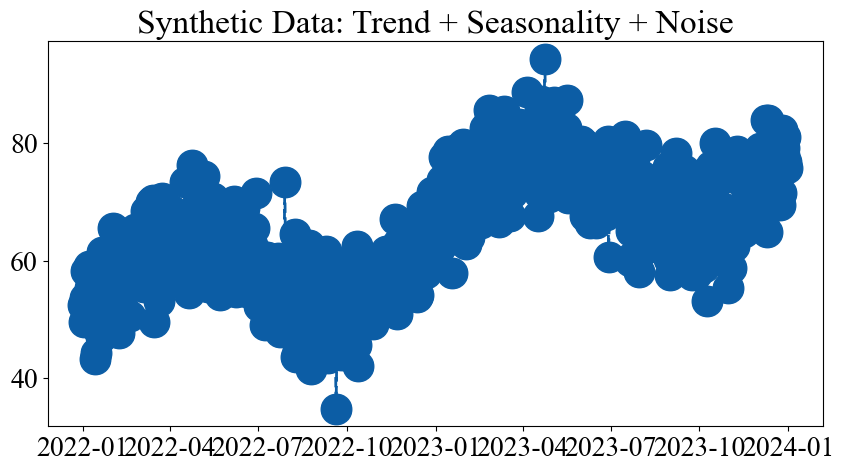

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing

# Generate synthetic Google Trends-like data
dates = pd.date_range('2022-01-01', '2023-12-31', freq='D')
np.random.seed(42)

# Create components: Trend, Seasonality, and Noise
trend = np.linspace(50, 80, len(dates))
seasonal = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 365.25)
noise = np.random.normal(0, 5, len(dates))

# Combine into a Series
ml_searches = pd.Series(trend + seasonal + noise, index=dates)

# Plot the synthetic data
plt.figure(figsize=(10, 5))
plt.plot(ml_searches)
plt.title("Synthetic Data: Trend + Seasonality + Noise")
plt.show()

Fitting the ETS Model

In [2]:
# Fit an ETS model
fit = ExponentialSmoothing(
    ml_searches,
    trend="add",
    seasonal="add",
    seasonal_periods=365
).fit()

/Users/ben/anaconda3/envs/ml_timeseries/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Generate a 60-day forecast and plotting the results

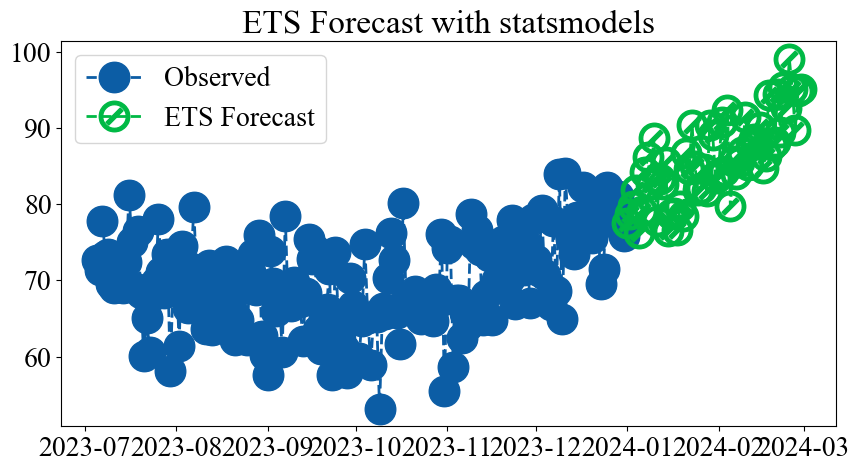

In [3]:
forecast = fit.forecast(60)

plt.figure(figsize=(10, 5))
plt.plot(ml_searches[-180:], label='Observed')
plt.plot(forecast, label='ETS Forecast', linestyle='--')
plt.title('ETS Forecast with statsmodels')
plt.legend()
plt.show()

find the optimal (p,d,q) parameters

In [4]:
import pmdarima as pm
dates = pd.date_range('2019-01-01', '2023-12-31', freq='D')
np.random.seed(42)

trend = np.linspace(50, 80, len(dates))
seasonal = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 365.25)
noise = np.random.normal(0, 5, len(dates))

ml_searches = pd.Series(trend + seasonal + noise, index=dates, name="value")

# Split into Train and Test
train_data = ml_searches[:'2023-10-31']
test_data = ml_searches['2023-11-01':]

Fourier Terms for Seasonality

In [5]:
def fourier_terms(index, period, K):
    """
    Generate Fourier terms for seasonality.
    """
    t = np.arange(len(index))
    cols = {}
    for k in range(1, K+1):
        cols[f'sin{k}'] = np.sin(2*np.pi*k*t/period)
        cols[f'cos{k}'] = np.cos(2*np.pi*k*t/period)
    return pd.DataFrame(cols, index=index)

PERIOD = 365.25
K = 3

train_exog = fourier_terms(train_data.index, PERIOD, K)
test_exog = fourier_terms(test_data.index, PERIOD, K)

Training AutoARIMA

In [6]:
arima_model = pm.auto_arima(
    train_data,
    X=train_exog,
    start_p=0, start_q=0, start_P=0,
    max_p=2, max_q=2,
    max_P=1, max_Q=1,
    seasonal=False,  # We handle seasonality via Exogenous variables (Fourier terms)
    d=1, D=1,
    stepwise=True,
    approximation=True,
    n_jobs=1,
    trace=False,
    error_action='ignore',
    suppress_warnings=True
)

print("\n--- Model Summary ---")
print(arima_model.summary())


--- Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -5348.224
Date:                Fri, 05 Dec 2025   AIC                          10712.449
Time:                        16:13:08   BIC                          10756.251
Sample:                    01-01-2019   HQIC                         10728.635
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin1           9.7962      0.388     25.235      0.000       9.035      10.557
cos1           0.0025      0.384      0.006      0.995      -0.750       0.755
sin2          -0.0262      0.

Generating Forecasts

In [7]:
n_periods = len(test_data)
forecast, conf_int = arima_model.predict(
    X=test_exog,
    n_periods=n_periods,
    return_conf_int=True
)

forecast_series = pd.Series(forecast, index=test_data.index)

Plotting the results

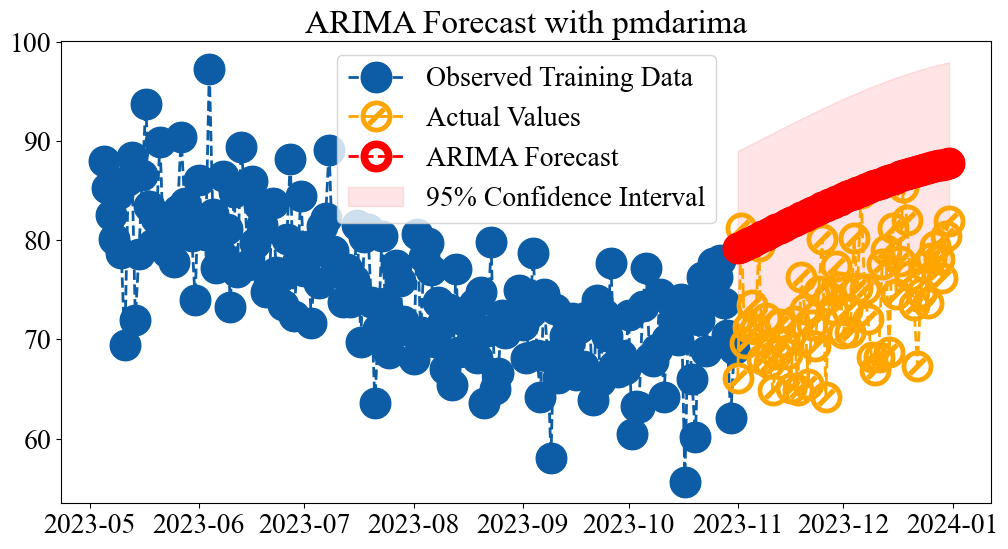

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(train_data[-180:], label='Observed Training Data')
plt.plot(test_data, label='Actual Values', color='orange')
plt.plot(forecast_series, label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(test_data.index,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='red', alpha=0.1, label='95% Confidence Interval')
plt.title('ARIMA Forecast with pmdarima')
plt.legend()
plt.show()

The Theta Method

In [11]:
from statsforecast import StatsForecast
from statsforecast.models import Theta

# Prepare DataFrame in the required format (unique_id, ds, y)
df = pd.DataFrame({
    'unique_id': 'ml_searches',
    'ds': ml_searches.index,
    'y': ml_searches.values
})

train_df = df[df['ds'] <= '2023-10-31']
test_df = df[df['ds'] > '2023-10-31']
# 1. Initialize the Theta model
models = [Theta(season_length=365)]

# 2. Create StatsForecast object
sf = StatsForecast(models=models, freq='D')

# 3. Fit to training data
sf.fit(train_df)

StatsForecast(models=[Theta])

Generate forecasts and plot

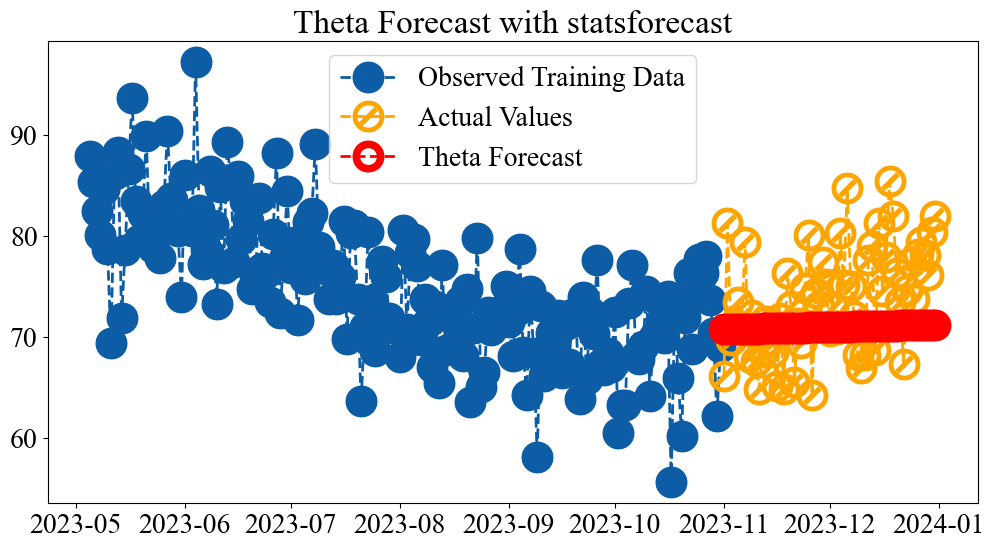

In [12]:
# 4. Generate forecasts
forecast_df = sf.predict(h=len(test_df))

plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'].tail(180), train_df['y'].tail(180), label='Observed Training Data')
plt.plot(test_df['ds'], test_df['y'], label='Actual Values', color='orange')
plt.plot(forecast_df['ds'], forecast_df['Theta'], label='Theta Forecast', color='red', linestyle='--')
plt.title('Theta Forecast with statsforecast')
plt.legend()
plt.show()